# RNA 动力学推断

使用剪接转录本和未剪接转录本的定量矩阵，我们可以借助此时间顺序推断细胞下一刻的转录水平

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import exprmat as em

# set working directory
em.setwd('/home/data/yangz/shared/tutorial/single-cell-rna')

In [3]:
ver = em.version()

[i] exprmat 0.1.48 / exprmat-db 0.1.48
[i] os: posix (linux)  platform version: 5.15.0-139-generic
[i] loaded configuration from /home/data/yangz/.exprmatrc
[i] current working directory: /home/data/yangz/shared/tutorial/single-cell-rna
[i] current database directory: /home/data/yangz/bioinfo/packages/database (0.1.48)
[i] resident memory: 811.36 MiB
[i] virtual memory: 5.78 GiB


### 从四个计数矩阵初始化剪接体表达矩阵

下面的数据给出了一个标准 10X 格式的表达矩阵，以及两个附加矩阵，分别记录剪接和未剪接计数矩阵：
我们需要以下的一个文件结构来自动加载剪接矩阵，这四个 MTX 矩阵和两个 TSV 文件是必须的

In [11]:
! tree -sh src/pancreas

src/pancreas
├── [ 15K]  barcodes.tsv.gz
├── [200K]  features.tsv.gz
├── [ 28M]  matrix.mtx.gz
├── [ 50M]  pancreas.h5ad
├── [9.3M]  spanning.mtx.gz
├── [ 28M]  spliced.mtx.gz
└── [9.3M]  unspliced.mtx.gz

0 directories, 7 files


In [8]:
meta = em.metadata(
    # two samples from a murine tumor infiltrating cd8+ t cell dataset.
    locations    = [
        'src/pancreas',
        'src/pancreas',
    ],
    modality     = ['rna', 'rna.splicing'],
    default_taxa = ['mmu', 'mmu'],
    batches      = ['b-1', 'b-1'],
    names        = ['pancreas', 'pancreas'],
    groups       = ['pancreas', 'pancreas'],
)

In [9]:
meta.dataframe

,location,sample,batch,group,modality,taxa
0,src/pancreas,pancreas,b-1,pancreas,rna,mmu
1,src/pancreas,pancreas,b-1,pancreas,rna.splicing,mmu


In [22]:
expm = em.experiment(meta, dump = 'pancreas-splicing')

[i] reading sample pancreas [rna] ...
[!] load pre-exisiting file `rna/pancreas.h5ad`.


In [13]:
print(expm)

[!] dataset not integrated.
[*] composed of samples:
  pancreas   rna   mmu    batch b-1     of size 3696 × 27543



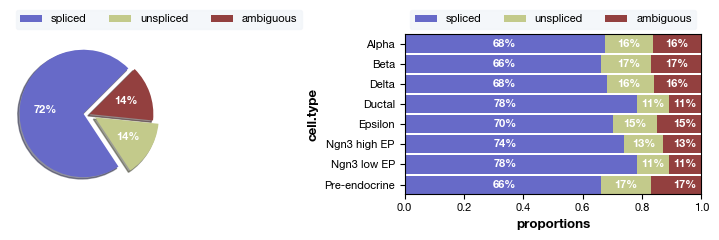

In [59]:
fig = expm.plot_rna_spliced_proportions(groupby = 'cell.type', figsize = (8, 2.5))

### 质量控制和可视化

RNA 动力学推断一般需要一个已经完成差异基因筛选、降维、分群和可视化的数据集，我们首先按照常规方法
对数据集进行处理，参见前述质量控制章节

In [23]:
expm.run_rna_qc(
    run_on_samples = True,
    mt_seqid = 'chrM',
    mt_percent = 0.15,
    ribo_genes = None,
    ribo_percent = None,
    outlier_mode = 'mads',
    outlier_n = 10,
    doublet_method = 'no',
    min_cells = 3,
    min_genes = 50,
    parallel = 3
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━ processing anndata       1 / 1     (00:03 < 00:00)


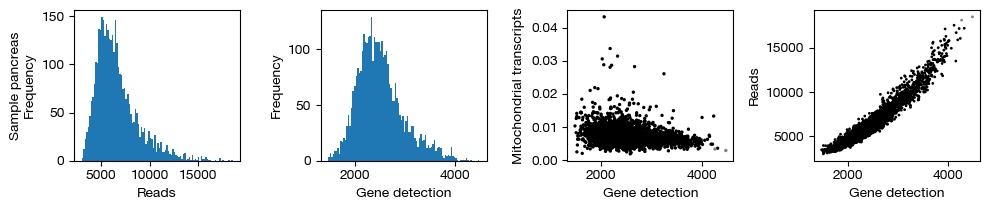

In [24]:
figs = expm.plot_rna_qc(run_on_samples = True)

In [25]:
expm.merge(join = 'outer')

In [26]:
expm.run_rna_log_normalize(
    key_norm = 'norm',
    key_lognorm = 'lognorm'
)

expm.run_rna_select_hvg(
    key_lognorm = 'X',
    method = 'vst',
    dest = 'vst',
    batch_key = 'batch',
    n_top_genes = 1500
)

In [27]:
expm.run_rna_scale_pca(
    hvg = 'vst.hvg',
    key_lognorm = 'lognorm',
    key_scaled = 'scaled',
    key_added = 'pca', n_comps = 35,
    keep_sparse = False,
    random_state = 42,
    svd_solver = 'arpack'
)

In [28]:
expm.run_rna_knn(
    use_rep = 'pca',
    n_comps = None,
    n_neighbors = 30,
    knn = True,
    method = "umap",
    transformer = None,
    metric = "cosine",
    metric_kwds = {},
    random_state = 42,
    key_added = 'neighbors'
)

expm.run_rna_leiden(
    resolution = 0.5,
    restrict_to = None,
    random_state = 42,
    key_added = 'leiden',
    adjacency = None,
    directed = None,
    use_weights = True,
    n_iterations = 2,
    partition_type = None,
    neighbors_key = None,
    obsp = None,
    flavor = 'igraph'
)

expm.run_rna_umap(
    min_dist = 0.5,
    spread = 1,
    n_components = 2,
    maxiter = None,
    alpha = 1,
    gamma = 1,
    negative_sample_rate = 5,
    init_pos = "spectral",
    random_state = 42,
    a = None, b = None,
    key_added = 'umap',
    neighbors_key = "neighbors"
)

现在，我们已经获得了一个降维表示并进行分群，根据作者提供的元数据，我们可以直接采用提供的分群信息，
可以注意到在目前的数据集 layers 中已经具有三个标准的剪接矩阵 `spliced`, `unspliced` 和 `ambiguous`，
这三个矩阵分别代表剪接体、未剪接体、和无法分类的横跨式 read 的计数矩阵

In [39]:
annots = em.pd.read_table('src/pancreas/annotation.tsv', index_col = 0)
expm['rna'].obs['cell.type'] = annots['clusters'].tolist()
expm['rna'].obs['cell.type'] = expm['rna'].obs['cell.type'].astype('category')
annots

,clusters
index,
AAACCTGAGAGGGATA,Pre-endocrine
AAACCTGAGCCTTGAT,Ductal
AAACCTGAGGCAATTA,Alpha
AAACCTGCATCATCCC,Ductal
AAACCTGGTAAGTGGC,Ngn3 high EP
...,...
TTTGTCAAGTGACATA,Pre-endocrine
TTTGTCAAGTGTGGCA,Ngn3 high EP
TTTGTCAGTTGTTTGG,Ductal


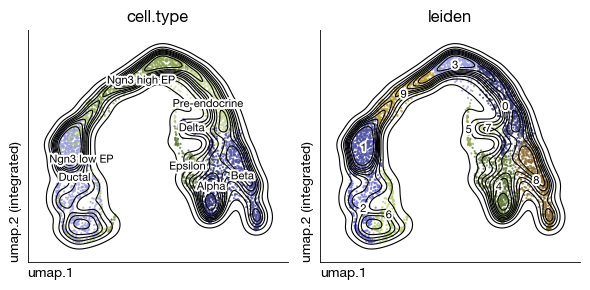

In [41]:
fig = expm.plot_rna_embedding_multiple(
    basis = 'umap', features = ['cell.type', 'leiden'], ncols = 2, cmap = 'category20b',
    figsize = (6, 3), dpi = 100, legend_col = 2, legend = False,
    ptsize = 2, annotate_style = 'text', annotate_fontsize = 8, contour_plot = True
)

In [42]:
print(expm)

annotated data of size 3696 × 17584
integrated dataset of size 3696 × 17584
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat> cell.type <cat>
    var : chr <o> start <i64> end <i64> strand <o> id <o> subtype <o> gene <o> tlen <f64>
          cdslen <i64> assembly <o> uid <o> vst.means <f64> vst.vars <f64> vst.vars.norm <f64>
          vst.hvg.rank <f32> vst.hvg <bool>
 layers : spliced <f64> unspliced <f64> ambiguous <f64> norm <f32> lognorm <f32> counts <f32>
   obsm : pca <arr:f64(35)> knn <arr:i32(30)> knn.d <arr:f64(30)> umap <arr:f32(2)>
   varm : pca <arr:f64(35)>
   obsp : connectivities <csr:f32> distances <csr:f64>
    uns : pca neighbors leiden umap leiden.colors cell.type.colors

[*] c

### RNA 速率推断

软件包已经实现随机速率推断

In [43]:
expm.run_rna_velocity(
    neighbor_key = 'neighbors', neighbor_connectivity = 'connectivities', 
    n_neighbors = 30, hvg = 'vst.hvg', velocity_key = 'velocity', 
    n_cpus = 100, 
    kwargs_filter = {}, 
    kwargs_velocity = { 'mode': 'stochastic' }, 
    kwargs_velocity_graph = {}, 
    kwargs_terminal_state = {}, 
    kwargs_pseudotime = { 'save_diffmap': True }
)

[i] normalized count data: spliced, unspliced.
[i] computing moments based on connectivities
[i] computing velocities ...
[i] computing velocity graph (using 100/144 cores)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━                       3696 / 3696  (00:09 < 00:00)


[i] computing terminal states ...
[i] identified 1 region of root cells and 1 region of end points .


`velocity.pseudotime`, `velocity.length`, `velocity.confidence` 和 `velocity.confidence.transition`
四个速率质量参数已经被计算并自动填入 obs 槽中，我们可以评估速率的可信度

In [44]:
print(expm)

annotated data of size 3696 × 17584
integrated dataset of size 3696 × 17584
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f32> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <cat> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <cat>
          leiden <cat> cell.type <cat> n.umi.unspliced <f64> n.umi.spliced <f64>
          velocity.self.transition <f32> root.cells <f64> endpoints <f64> velocity.pseudotime <f64>
          velocity.length <f32> velocity.confidence <f64> velocity.confidence.transition <f32>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <o> tlen <f64>
          cdslen <i64> assembly <cat> uid <o> vst.means <f64> vst.vars <f64> vst.vars.norm <f64>
          vst.hvg.rank <f32> vst.hvg <bool> velocity.gamma <f32> velocity.qreg.ratio <f32>
          velocity.r2 <f64> velocity.genes <

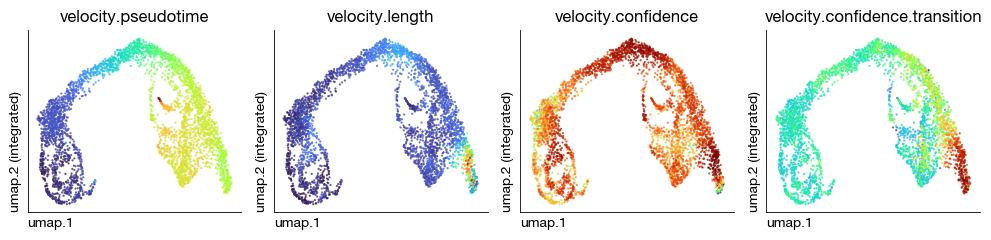

In [45]:
fig = expm.plot_rna_embedding_multiple(
    basis = 'umap', features = [
        'velocity.pseudotime', 'velocity.length', 'velocity.confidence', 'velocity.confidence.transition'
    ], ncols = 4, cmap = 'turbo',
    figsize = (10, 2.5), dpi = 100, legend_col = 2, legend = False,
    ptsize = 2, annotate_style = 'text', annotate_fontsize = 8, contour_plot = False
)

给定一个二维底图，我们可以将高维的速率向量投影到 UMAP 上以便可视化

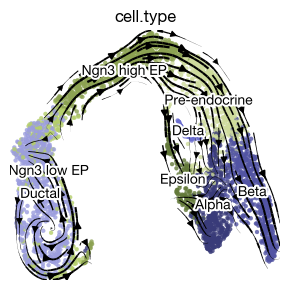

In [50]:
fig = expm.plot_rna_velocity_streamline(
    basis = 'umap', vkey = "velocity",
    neighbor_key = 'neighbors', frameon = False,
    color = 'cell.type', contour_plot = False, figsize = (3, 3), dpi = 100,
    density = 1.5, annotate_style = 'text', annotate_fontsize = 10
)

### 保存数据集

保存整合的数据集

In [51]:
expm.save(save_samples = False)

[i] main dataset write to pancreas-splicing/integrated.h5mu
